# **Milestone 3:**

**Agustín Krebs, Axel Rusnak, Alex Sjöberg.**

### Some follow up discussion on M2:


We want to test if there exists enough information in MIDI-files to capture the genre of a specific song. Most MIR is done on Audio rather than midi-files and there has been a discussion whether the FoM (figure of merit) of common MIR systems comes from the system using characteristics confounded with the “ground truth” of the dataset. This would imply these MIR systems are not addressing the musical problem for which it was designed. Using a generative approach that rely only on MIDI information, plenty of the irrelevant transformations could be avoided and the system would be more designed to solve a musical problem. 

Best Case: the model is successful in generating music related to different genres. We can in the post-analysis e.g. analyze the differences in the edit-distance and connect those findings to musicological concepts. The connection to musicological concepts can give us more further insight to what quantifiable components actually makes up/characterizes genre. 

Worst Case: Worst case our model is not successful in generating music relating to different genres. The output is inconsequent or insignificant and we cannot draw any conclusions (Outside of the fact that our method is insufficient for capturing information and generating music on that information).


# **1. Genres distribution**

We want to have the songs separated in genres. Most songs have tags in the metadata, these are used to from the genres whoch we at a later stage will use as a basis for our analysis. 



In [0]:
# Imports
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import pretty_midi
import librosa
import mir_eval
import mir_eval.display
import tables
import IPython.display
import os
import json
import hdf5_getters as getters
import pandas as pd
from scipy.stats import pearsonr
from collections import Counter

# Local path constants
DATA_PATH = 'data'
RESULTS_PATH = 'Data'
# Path to the file match_scores.json distributed with the LMD
SCORE_FILE = os.path.join(RESULTS_PATH, 'match_scores.json')
TAGS_FILE = os.path.join(RESULTS_PATH, 'unique_tracks.txt')

# Utility functions for retrieving paths
def msd_id_to_dirs(msd_id):
    """Given an MSD ID, generate the path prefix.
    E.g. TRABCD12345678 -> A/B/C/TRABCD12345678"""
    return os.path.join(msd_id[2], msd_id[3], msd_id[4], msd_id)

def msd_id_to_mp3(msd_id):
    """Given an MSD ID, return the path to the corresponding mp3"""
    return os.path.join(DATA_PATH, 'msd', 'mp3',
                        msd_id_to_dirs(msd_id) + '.mp3')

def msd_id_to_h5(h5):
    """Given an MSD ID, return the path to the corresponding h5"""
    return os.path.join(RESULTS_PATH, 'lmd_matched_h5',
                        msd_id_to_dirs(msd_id) + '.h5')

def get_midi_path(msd_id, midi_md5, kind):
    """Given an MSD ID and MIDI MD5, return path to a MIDI file.
    kind should be one of 'matched' or 'aligned'. """
    return os.path.join(RESULTS_PATH, 'lmd_{}'.format(kind),
                        msd_id_to_dirs(msd_id), midi_md5 + '.mid')

In [0]:
with open(SCORE_FILE) as f:
    scores = json.load(f)
  
# ------- If we want more metadata -------
#meta_tags = pd.read_csv(TAGS_FILE, names=["msd_id", "song_id", "artist_name", "song_title"], sep = '<SEP>')
#meta_tags = meta_tags.set_index('msd_id').T.to_dict('list')

UDFs

In [0]:
def get_most_helper(msd_id,n):
    to_h5 = msd_id_to_h5(msd_id)
    with tables.open_file(to_h5) as h5:
        return list(h5.root.metadata.artist_terms)[:n]
    
def get_all(msd_id):
    to_h5 = msd_id_to_h5(msd_id)
    with tables.open_file(to_h5) as h5:
        return list(h5.root.metadata.artist_terms)
    
def get_info(msd_id):
    to_h5 = msd_id_to_h5(msd_id)
    with tables.open_file(to_h5) as h5:
        return list(h5.root.metadata.artist_terms_weight)

def get_most_common(m_id,n):
    msd_id = m_id
    temp_list = []
    l = get_most_helper(msd_id,n)
    for i in l:
        #print(i.decode('UTF-8'))
        temp_list.append(i.decode('UTF-8'))
    return  temp_list

def add_to_genres_to_msd(dictionary, m_id, n):
    dictionary[m_id] = get_most_common(m_id,n)
    
def add_msd_to_genres(dictionary, m_id, n):
    msd_id = m_id
    temp_list = get_most_common(msd_id,n)
    for i in temp_list:
        # Check if it is in the dict before otherwise add it
        if i in dictionary:
            dictionary[i].append(m_id)
        else:
            dictionary[i] = [m_id]
    return

# Have to do outside!
def get_all_genres(n):
    d = {}
    scores_list = list(scores.keys())
    end_i = len(scores_list)-1
    #end_i = len(list(scores.keys()))-1
    for i in range(0,10):
        msd_id = scores_list[i]
        print(msd_id)
        #add_msd_to_genres(d,msd_id,n)
        temp_list = get_most_common(msd_id,n)
        print(get_most_common(msd_id,n))
        d[msd_id] = temp_list
        del(temp_list,msd_id)
    return d

def get_specific_genres(l,n):
    return

def get_genre_dist(d):
    temp_d = d.copy()
    for k in d.keys():
        temp_d[k] = len(d[k])
    temp_list = list(d.values())
    lat_list = [item for sublist in temp_list for item in sublist]
    den = len(list(set(lat_list)))
    a = temp_d.copy()
    #return {k: v / total for total in (sum(a.values()),) for k, v in a.items()}
    return {k: v / den for k, v in a.items()}


In [0]:
with open(SCORE_FILE) as f:
    tags = json.load(f)

In [0]:
# For some reason we cant put this as a function, then it doesn't work. Really weird
d = {}
end_i = len(list(scores.keys()))-1
for i in range(0,end_i):
    msd_id = list(scores.keys())[i]
    a = get_info(msd_id)
    n = len([i for i in a if i >= 0.90])
    add_msd_to_genres(d,msd_id,n)

In [0]:
dist = get_genre_dist(d)
distribution_sorted = {k: v for k, v in sorted(dist.items(), key=lambda item: item[1],reverse = True)}

In [0]:
def get_dict_over_percentage(d,p):
    return {k:v for k, v in d.items() if v > p}


top_distribution = get_dict_over_percentage(distribution_sorted,0.025)

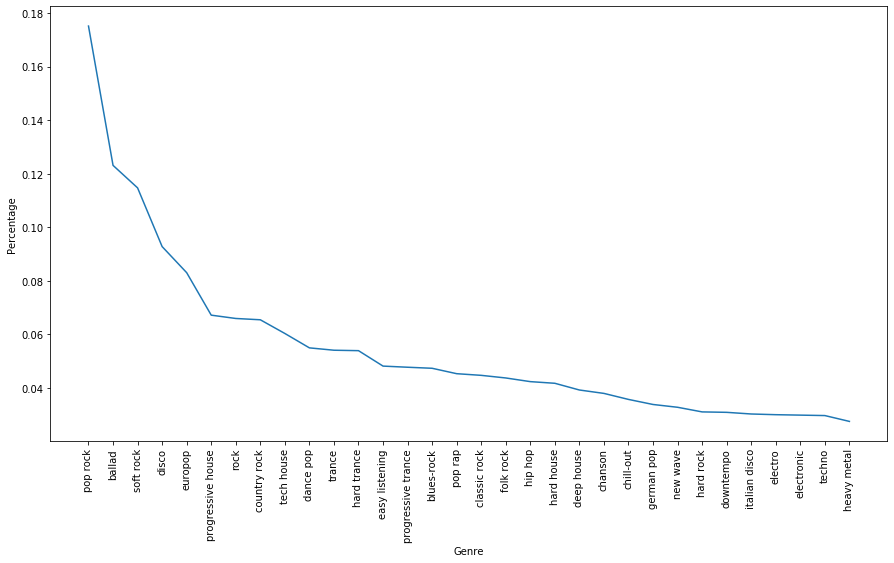

In [0]:
lists = top_distribution.items() # sorted by key, return a list of tuples

x, y = zip(*lists) # unpack a list of pairs into two tuples
plt.figure(figsize = (15,8))
plt.plot(x, y)
plt.xticks(rotation=90)
plt.xlabel('Genre')
plt.ylabel('Percentage')
plt.show()


We can see that every genre accounts for relatively little part of the total corpus. We want to model two or three genres that are relativeley different, or perhaps 4 where two are more similar. We have to make up or mind which direction we wanna go here. 

In [0]:
country_rock_corpus = d['country rock']
hip_hop_corpus = d['hip hop']
disco_corpus = d['disco']


print('Length of: "country rock corpus" is ' + str(len(country_rock_corpus)) + ' songs')
print('Length of: "hip hop corpus" is ' + str(len(hip_hop_corpus)) + ' songs')
print('Length of: "disco corpus" is ' + str(len(disco_corpus)) + ' songs')


Length of: "country rock corpus" is 2010 songs
Length of: "hip hop corpus" is 1301 songs
Length of: "disco corpus" is 2849 songs


If we can divide the song into snipets of 20-30 seconds we can significanlty increase the size of our data. In the magenta project they had 200 hours of recorded audio. If we roughly estimate that each song in the YAMAHA dataset that they used were ~ 3.5 min, this means they had around 3500 songs. This means that the data input for the three categories above might be sufficient. 

In [0]:
temp_list = list(d.values())
lat_list = [item for sublist in temp_list for item in sublist]
den = len(list(set(lat_list)))

dict_songs = {k: int(v * den,) for k, v in top_distribution.items()}

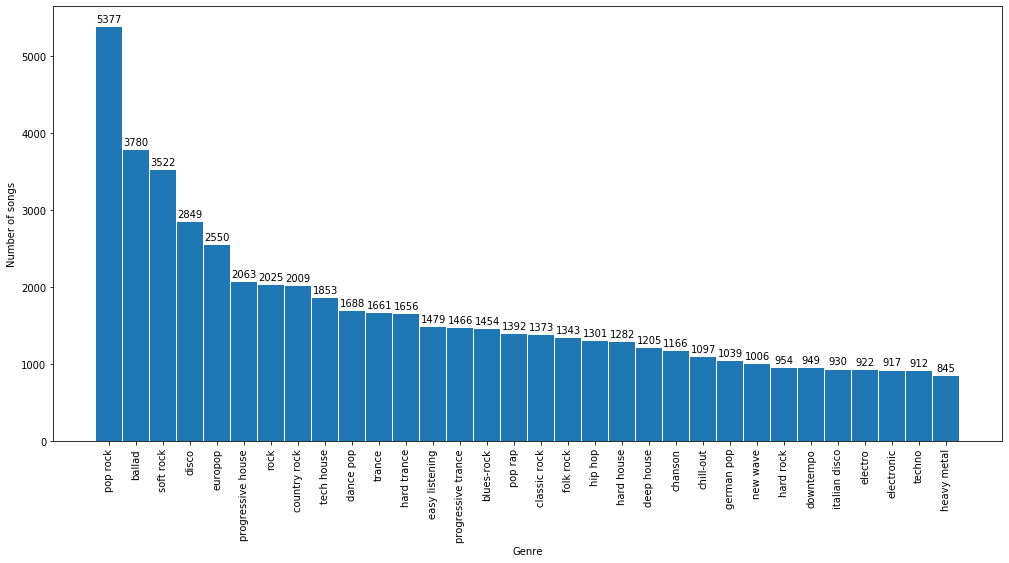

In [0]:
lists = dict_songs.items() # sorted by key, return a list of tuples

x, y = zip(*lists) # unpack a list of pairs into two tuples

fig, ax = plt.subplots(figsize = (17,8))

width = 0.95

rects = ax.bar(x, y,width)


def autolabel(rects):
    """Attach a text label above each bar in *rects*, displaying its height."""
    for rect in rects:
        height = rect.get_height()
        ax.annotate('{}'.format(height),
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')


autolabel(rects)
plt.xticks(rotation=90)
plt.xlabel('Genre')
plt.ylabel('Number of songs')
plt.show()



**Correlation of genres:**

In [0]:
top_keys = list(top_distribution.keys())
top_keys 

['pop rock',
 'ballad',
 'soft rock',
 'disco',
 'europop',
 'progressive house',
 'rock',
 'country rock',
 'tech house',
 'dance pop',
 'trance',
 'hard trance',
 'easy listening',
 'progressive trance',
 'blues-rock',
 'pop rap',
 'classic rock',
 'folk rock',
 'hip hop',
 'hard house',
 'deep house',
 'chanson',
 'chill-out',
 'german pop',
 'new wave',
 'hard rock',
 'downtempo',
 'italian disco',
 'electro',
 'electronic',
 'techno',
 'heavy metal']

In [0]:
# Functions for correlation metrics
def jaccard_similarity(list1, list2):
    intersection = len(list(set(list1).intersection(list2)))
    union = (len(list1) + len(list2)) - intersection
    return float(intersection) / union


def get_column_jaccard(d,gen,top_keys):
    list_of_songs1 = d[gen]
    scores = []
    for i in top_keys:
        score = jaccard_similarity(d[gen], d[i])
        scores.append(score)
    return scores

def get_column_pearson(d,gen,top_keys):
    l = list(d.values())
    flatten = [item for sublist in l for item in sublist]
    s = list(set(flatten))  
    
    sparse_array_gen = get_row_values(s,d[gen])
    scores = []
    for i in top_keys:
        sparse_array_2 = get_row_values(s,d[i])
        score = pearsonr(sparse_array_gen, sparse_array_2)[0]
        scores.append(score)
    return scores

def get_row_values(s,l):
    a = np.empty(len(s), dtype=int) 
    for i in range(0,len(s)):
        there = 0
        if s[i] in l:
            there = 1
        a[i] = there
    return a
 
def get_corr_df(d, columns, method='jaccard'):
    df = pd.DataFrame(0, index=columns , columns=columns)
    for k in columns:
        col_vals = []
        if method is 'jaccard':
            col_vals = get_column_jaccard(d,k,columns)
            df[k] = col_vals
        if method is 'pearson':
            col_vals = get_column_pearson(d,k,columns)
            df[k] = col_vals
    return df 




In [0]:
## WARNIGN LONG RUNTIME ~ 20 min, set a = True to run
a = False
df_jaccard_correlation = get_corr_df(d, top_keys)
if a is True:
    df_pearson_correlation = get_corr_df(d, top_keys,method='pearson')

In [0]:
df_jaccard_correlation

pop rock    ballad  soft rock     disco   europop  \
pop rock            1.000000  0.286818   0.351405  0.153879  0.176986   
ballad              0.286818  1.000000   0.269471  0.204397  0.254459   
soft rock           0.351405  0.269471   1.000000  0.126813  0.121951   
disco               0.153879  0.204397   0.126813  1.000000  0.218186   
europop             0.176986  0.254459   0.121951  0.218186  1.000000   
progressive house   0.032186  0.040235   0.016379  0.081462  0.114520   
rock                0.076028  0.037348   0.057780  0.024595  0.024407   
country rock        0.105673  0.106863   0.143684  0.051277  0.028881   
tech house          0.021908  0.021767   0.006177  0.078440  0.082350   
dance pop           0.036684  0.040335   0.025792  0.074609  0.065359   
trance              0.014852  0.019487   0.002902  0.052018  0.102068   
hard trance         0.020459  0.021421   0.007785  0.050117  0.093888   
easy listening      0.031753  0.065006   0.072946  0.024136  0.009269   
progressive trance  0.011082  0.014896   0.006051  0.031556  0.064970   
blues-rock          0.123889  0.084317   0.110962  0.040629  0.021950   
pop rap             0.103341  0.119965   0.049551  0.129127  0.295432   
classic rock        0.125375  0.064230   0.117070  0.049988  0.019491   
folk rock           0.098937  0.065294   0.107948  0.023937  0.029894   
hip hop             0.043601  0.049577   0.011535  0.063012  0.092172   
hard house          0.026040  0.027609   0.011156  0.076903  0.115575   
deep house          0.024117  0.022354   0.009396  0.088030  0.062535   
chanson             0.089048  0.164861   0.089472  0.072382  0.096165   
chill-out           0.021780  0.029555   0.025761  0.025201  0.025591   
german pop          0.068621  0.126724   0.064908  0.087552  0.130394   
new wave            0.070064  0.029684   0.031193  0.055860  0.044334   
hard rock           0.064391  0.013704   0.017735  0.005819  0.014476   
downtempo           0.043894  0.065810   0.027580  0.096420  0.075623   
italian disco       0.067536  0.083506   0.044335  0.147934  0.158841   
electro             0.015640  0.012925   0.005202  0.065856  0.030267   
electronic          0.051453  0.049140   0.020225  0.127545  0.130421   
techno              0.012070  0.012079   0.006127  0.030693  0.041203   
heavy metal         0.021843  0.002601   0.005758  0.003532  0.004141   

                    progressive house      rock  country rock  tech house  \
pop rock                     0.032186  0.076028      0.105673    0.021908   
ballad                       0.040235  0.037348      0.106863    0.021767   
soft rock                    0.016379  0.057780      0.143684    0.006177   
disco                        0.081462  0.024595      0.051277    0.078440   
europop                      0.114520  0.024407      0.028881    0.082350   
progressive house            1.000000  0.007145      0.002215    0.355956   
rock                         0.007145  1.000000      0.042905    0.011740   
country rock                 0.002215  0.042905      1.000000    0.006514   
tech house                   0.355956  0.011740      0.006514    1.000000   
dance pop                    0.030211  0.005416      0.002983    0.016069   
trance                       0.326683  0.000815      0.000545    0.205075   
hard trance                  0.253877  0.005463      0.000273    0.196386   
easy listening               0.005393  0.010672      0.020772    0.000601   
progressive trance           0.374221  0.002873      0.002307    0.187903   
blues-rock                   0.008314  0.048523      0.103888    0.005167   
pop rap                      0.120298  0.019696      0.009795    0.091123   
classic rock                 0.010588  0.137216      0.083253    0.002486   
folk rock                    0.006204  0.074322      0.135071    0.006297   
hip hop                      0.055207  0.006963      0.002422    0.049235   
hard house                   0.273800  0.001211      0.002741    0.218

In [0]:
df_pearson_correlation

pop rock    ballad  soft rock     disco   europop  \
pop rock            1.000000  0.359670   0.456397  0.176652  0.231484   
ballad              0.359670  1.000000   0.347277  0.264533  0.348457   
soft rock           0.456397  0.347277   1.000000  0.137460  0.136113   
disco               0.176652  0.264533   0.137460  1.000000  0.297112   
europop             0.231484  0.348457   0.136113  0.297112  1.000000   
progressive house  -0.044238 -0.011068  -0.059856  0.080079  0.142690   
rock                0.058143 -0.016085   0.029128 -0.032057 -0.028132   
country rock        0.122654  0.124864   0.191915  0.022924 -0.018569   
tech house         -0.060983 -0.044998  -0.077052  0.080172  0.089764   
dance pop          -0.017136  0.001830  -0.028073  0.078003  0.062042   
trance             -0.071160 -0.044025  -0.079297  0.034187  0.131510   
hard trance        -0.056514 -0.039429  -0.067839  0.030490  0.116763   
easy listening     -0.019202  0.064318   0.081315 -0.018465 -0.047302   
progressive trance -0.073023 -0.048097  -0.066214 -0.002114  0.068223   
blues-rock          0.201074  0.106412   0.158901  0.017492 -0.019306   
pop rap             0.160742  0.182318   0.035539  0.192008  0.444422   
classic rock        0.212100  0.068096   0.175801  0.039981 -0.022280   
folk rock           0.154956  0.072061   0.159893 -0.014602  0.000850   
hip hop             0.021774  0.039292  -0.047804  0.069821  0.127116   
hard house         -0.023770 -0.010810  -0.048050  0.098802  0.171426   
deep house         -0.024714 -0.020079  -0.049586  0.124983  0.073502   
chanson             0.148316  0.288586   0.134352  0.095622  0.141506   
chill-out          -0.024972  0.002649  -0.005409 -0.002891 -0.000062   
german pop          0.109030  0.227013   0.089776  0.134470  0.213906   
new wave            0.116272  0.007814   0.012337  0.069689  0.044646   
hard rock           0.106650 -0.030528  -0.018508 -0.043031 -0.019877   
downtempo           0.049425  0.100333   0.006586  0.159526  0.114013   
italian disco       0.118075  0.143739   0.049098  0.262464  0.275298   
electro            -0.032359 -0.031072  -0.049555  0.096988  0.017589   
electronic          0.074218  0.062379  -0.010314  0.224828  0.224542   
techno             -0.042751 -0.032853  -0.046719  0.018107  0.042591   
heavy metal        -0.007839 -0.055755  -0.044930 -0.044875 -0.040523   

                    progressive house      rock  country rock  tech house  \
pop rock                    -0.044238  0.058143      0.122654   -0.060983   
ballad                      -0.011068 -0.016085      0.124864   -0.044998   
soft rock                   -0.059856  0.029128      0.191915   -0.077052   
disco                        0.080079 -0.032057      0.022924    0.080172   
europop                      0.142690 -0.028132     -0.018569    0.089764   
progressive house            1.000000 -0.056108     -0.066292    0.493586   
rock                        -0.056108  1.000000      0.017745   -0.042539   
country rock                -0.066292  0.017745      1.000000   -0.053244   
tech house                   0.493586 -0.042539     -0.053244    1.000000   
dance pop                   -0.001944 -0.052571     -0.057475   -0.027518   
trance                       0.463190 -0.061800     -0.062124    0.300951   
hard trance                  0.369592 -0.051821     -0.062604    0.288241   
easy listening              -0.048826 -0.037097     -0.015873   -0.055728   
progressive trance           0.526225 -0.053341     -0.054318    0.279996   
blues-rock                  -0.042069  0.040228      0.143099   -0.045551   
pop rap                      0.173516 -0.016271     -0.036784    0.122935   
classic rock                -0.035401  0.202820      0.108386   -0.049532   
folk rock                   -0.044035  0.092671      0.200292   -0.040821   
hip hop                      0.057216 -0.040907     -0.050438    0.047182   
hard house                   0.411608 -0.052838     -0.049317    0.331

In [0]:
df_jaccard_correlation['hard rock']

pop rock              0.064391
ballad                0.013704
soft rock             0.017735
disco                 0.005819
europop               0.014476
progressive house     0.001328
rock                  0.094416
country rock          0.021717
tech house            0.007538
dance pop             0.008397
trance                0.001916
hard trance           0.001535
easy listening        0.008288
progressive trance    0.001241
blues-rock            0.064545
pop rap               0.011207
classic rock          0.106515
folk rock             0.013233
hip hop               0.009400
hard house            0.001343
deep house            0.023708
chanson               0.003788
chill-out             0.004407
german pop            0.017356
new wave              0.031020
hard rock             1.000000
downtempo             0.001579
italian disco         0.001595
electro               0.002672
electronic            0.002680
techno                0.002687
heavy metal           0.316020
Name: ha

The correlation metrics make sense, those genres we assumed would be more closly correlated, such as pop rock and soft rock, exhibited a higher correlation both when using pearson and jaccard. Analogusly country rock was very uncorrelated with hip hop. If we want to use 4 genres to train the generative model, our idea currently is to use 2 genres which are more correlated and 2 genres that are also more correlated to one antoher, while it is very uncorrelated for the first two genres. It is furthermore important that the genres have the instruments that we wish to use for our generative model. More on that in the instrument part.

# **Questions:**

**Which analyses or experiments did you perform and what are the results? Choose suitable visualizations to show your results.**

To train the models we use the matched data in the million song dataset. We have decided to use 4 different genres as inputs. Two who are more correlated and two how are very uncorrelated with the first two genres, but correlated with one another. In order to find these genres we first extracted the number of songs in our data that were tagged with a specific genre. The tagging of the songs comes from Echo Nest lab and is based on tags by artist. For each song we get all the tags from the artist that made the songs. For a song the counts for each of the genres are divided by the counts for the most frequent genre. In order to get the tags most associated with the data, we only keep those with a score over 0.90. This to only remain the tags that are most relevant to the artist. This method has one drawback and that is that we assume that the song in the matched data is within the artist normal genre style. In the figures above you see how many of the songs were tagged with a certain genre. Only the top ones are shown. Moreover, we also show how many of the songs that are tagged with a certain genre.

Once we had the all of the songs tagged by a certain gene we could make correlations to see which genres were usually tagged together. We did these correlations by creating a sparse matrix where genres were the rows and all of the songs in the dataset were the columns. For the songs that were in a genre this generated a 1 in that columns of those songs.

Using the arrays we have identified above we calculated the pearson correlation amongst all of the most frequent genres. We also calculated the jaccard correlation among all the most frequent genres. The result is shown in the notebook.



**How do the results relate to your hypotheses?**

The correlation metrics make sense, those genres we assumed would be more closely correlated, such as pop rock and soft rock, exhibited a high correlation both when using pearson and jaccard. Analogously country rock was very uncorrelated with hip hop. If we want to use 4 genres to train the generative model, our idea currently is to use 2 genres which are more correlated and 2 genres that are also more correlated to one another, while it is very uncorrelated for the first two genres. It is furthermore important that the genres have the instruments that we wish to use for our generative model. That is why we also calculated the instrument distribution for all the genres. This is also shown in the notebook. This distribution is follows relatively well with our expectation. We see that for heavy metal piano is not so frequent while for soft rock it is very frequent. Bass and drums are almost always the two most frequent instruments. It is quite reasonable to assume that piano and guitar often have a similar role in much music, to produce melody. Thus using one of these should be enough to capture the necessary essence for the melody. 

**Did you find interesting or unexpected things? How do they influence your project?**

None of the genres seemed to correlate to much which is a nice property. The correlation plays a role in which genres we choose to have as input in our models, as mentioned above. The instrument distribution also play an important role when selecting the genres. We want the genres to have a high frequency of the instruments we have decided to use. 

**What are problems that you encountered? How could you plan to deal with them?**

The problems associated with inaccurate genre tags is unfortunately out of our hands, we simply have accept inaccuracies as noise. The data on genres is quite limited and to train a neural network we need a lot of data. We have explored options as using Spotify’s public API to get genre information, but they don’t have that information for the songs, they rely more on parameters as energy, valence etc. It is not so difficult to see why this is the case as genre as we’ve come to learn is quite a difficult concept to quantify and formalize. 
Of course we lose a lot of information on essential characteristics of certain genres when we amit omit either the piano or the guitar e.g for metal the distortion of the guitar is a characteristic. So we need to consider to keep the instrument that is most important for the genres we use as input, or use genres with more suitable instruments.


# **2. Distribution and merging of Instruments**

In this section we analyze the distribution of instruments across our dataset

In [1]:
!pip3 install pretty_midi

In [0]:
import os
import tqdm
import pretty_midi
from collections import defaultdict, Counter
import matplotlib.pyplot as plt
import json
from random import sample
import pandas as pd
import IPython.display

In [3]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [4]:
!ls 'gdrive/Shared drives/Digital Musicology 2020'

 data
'Distribution of instruments.ipynb'
 distributions.json
'Instruments Conversion.gsheet'
 lmd_aligned.tar.gz
'M1: Project Proposal.gdoc'
'M2: Data gathering and preprocessing.gdoc'
'M3: Exploratory Analysis and Initial Results.gdoc'
 Milestone2.ipynb
'Project Plan 2.0.gdoc'
'Separating genres script.ipynb'


In [0]:
data_path = 'gdrive/Shared drives/Digital Musicology 2020/data'
os.chdir(data_path)

In [0]:
"""
all_midi_paths = list()
i = 0
for root, dirs, files in os.walk("lmd_aligned/", topdown = False):
  for name in files:
    if not i%1000:
      print(i)
    all_midi_paths.append(os.path.join(root, name))
    i += 1

with open("../all_midis_paths.txt", "w") as file:
  for midi_path in all_midi_paths:
    file.write(midi_path + "\n")
"""
with open("all_midis_paths.txt", "r") as file:
  all_midi_paths = [line for line in file]

In [0]:
all_midi_dirs = set([midi_path[1:27] for midi_path in all_midi_paths])

In [0]:
with open("match_scores.json") as file:
    scores = json.load(file)

In [9]:
sample_size = int(len(all_midi_dirs)*0.1)
"""
instruments_counts = defaultdict(int)
errors_count = 0
sample_size = int(len(all_midi_dirs)*0.1)
print(f"Sample size: {sample_size}")
for i, midi_dir in enumerate(sample(all_midi_dirs, sample_size)):
  if not i%100:
    print(i)
  midi_path = list(scores[midi_dir[7:25]].keys())[0]
  try:
    pm = pretty_midi.PrettyMIDI("lmd_aligned" + midi_dir + midi_path + ".mid")
    for instrument in pm.instruments:
      if not instrument.is_drum:
        instruments_counts[instrument.program] += 1
  except:
    errors_count += 1

instruments_counts = dict(instruments_counts)
print(f"There were {errors_count} MIDI files with errors")

instruments_counts_str = {str(k): str(v) for k, v in instruments_counts.items()}
with open('instruments_counts.json', 'w') as json_file:
  json.dump(instruments_counts_str, json_file)
"""
with open('instruments_counts.json') as file:
    instruments_counts_str = json.load(file)

instruments_counts = {int(k): int(v) for k, v in instruments_counts_str.items()}
instruments_counts = Counter(instruments_counts)
instruments_counts

Counter({0: 1694,
         1: 368,
         2: 142,
         3: 80,
         4: 273,
         5: 235,
         6: 90,
         7: 98,
         8: 36,
         9: 38,
         10: 39,
         11: 178,
         12: 40,
         13: 18,
         14: 32,
         15: 8,
         16: 128,
         17: 157,
         18: 222,
         19: 38,
         20: 20,
         21: 53,
         22: 87,
         23: 22,
         24: 501,
         25: 999,
         26: 455,
         27: 691,
         28: 389,
         29: 510,
         30: 580,
         31: 28,
         32: 413,
         33: 1033,
         34: 186,
         35: 608,
         36: 41,
         37: 42,
         38: 267,
         39: 206,
         40: 100,
         41: 37,
         42: 61,
         43: 46,
         44: 49,
         45: 116,
         46: 104,
         47: 66,
         48: 1034,
         49: 588,
         50: 447,
         51: 96,
         52: 518,
         53: 320,
         54: 180,
         55: 41,
         56: 184,
       

In [0]:
instruments_relative_freq = {inst_program: freq/sample_size for inst_program, freq in instruments_counts.items()}

Taking a sample of the 10% of the dataset, we counted the amount of all the 128 different possible instruments. Here you can see the distribution among these instruments:

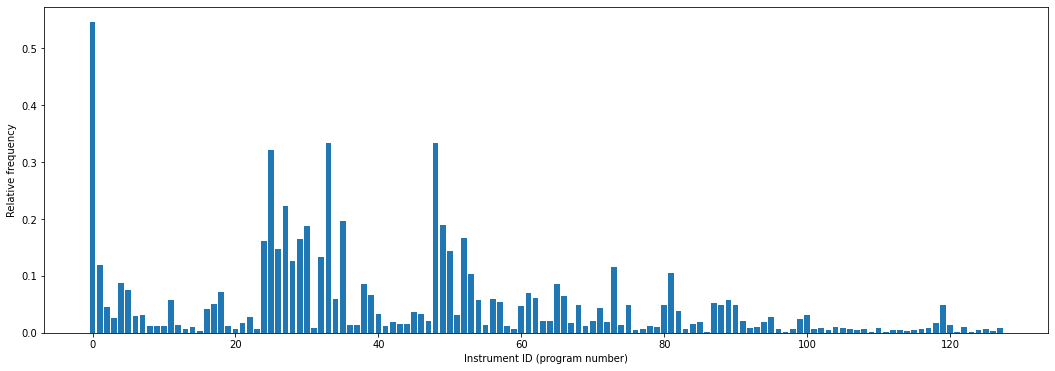

In [11]:
plt.figure(figsize=(18, 6))
plt.bar(instruments_relative_freq.keys(), instruments_relative_freq.values())
plt.xlabel("Instrument ID (program number)")
plt.ylabel("Relative frequency")
plt.show()

It is relevant how unequal de distribution is. Anyways, the program number of the instruments doesn't say much, so we plotted the top 50 most frequent instruments in the dataset:

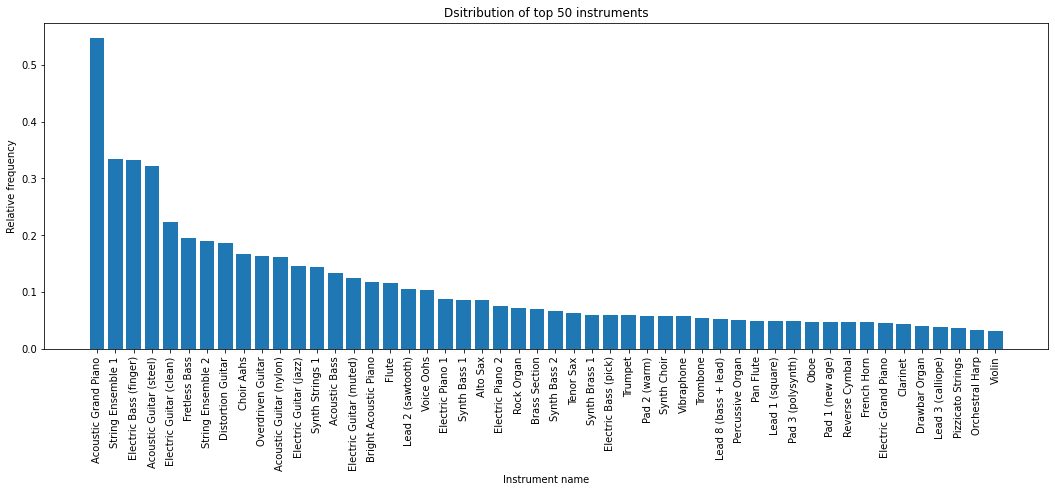

In [12]:
n = 50
top_n_inst_w_names = {pretty_midi.program_to_instrument_name(program): freq/sample_size for program, freq in instruments_counts.most_common(n)}
plt.figure(figsize=(18,6))
plt.bar(top_n_inst_w_names.keys(), top_n_inst_w_names.values())
plt.xlabel("Instrument name")
plt.ylabel("Relative frequency")
plt.title(f"Dsitribution of top {n} instruments")
plt.xticks(rotation='90')
plt.show()

As one can see, the most common instruments are the family of pianos, strings, guitars, and basses. This distribution doesn't take into account percussion instruments (since they are grouped all in the same channel, so the analysis is a bit different).

In [13]:
relative_frequency_dict = {pretty_midi.program_to_instrument_name(program): freq/sample_size for program, freq in instruments_counts.most_common()}
instruments_df = pd.DataFrame()
instrument_program_number_column = list()
instrument_name_column = list()
instrument_relative_frequency_column = list()
for i in range(128):
  instrument_program_number_column.append(i)
  instrument_name_column.append(pretty_midi.program_to_instrument_name(i))
  instrument_relative_frequency_column.append(relative_frequency_dict[pretty_midi.program_to_instrument_name(i)])
instruments_df["Program N"] = instrument_program_number_column
instruments_df["Name"] = instrument_name_column
instruments_df["Relative Frequency"] = instrument_relative_frequency_column
instruments_df

Program N                   Name  Relative Frequency
0            0   Acoustic Grand Piano            0.546099
1            1  Bright Acoustic Piano            0.118633
2            2   Electric Grand Piano            0.045777
3            3       Honky-tonk Piano            0.025790
4            4       Electric Piano 1            0.088008
..         ...                    ...                 ...
123        123             Bird Tweet            0.000967
124        124         Telephone Ring            0.005480
125        125             Helicopter            0.007415
126        126               Applause            0.003868
127        127                Gunshot            0.008382

[128 rows x 3 columns]

Since the instrument distribution is so sparce, we decided to make conversions between instruments, since the model (and the aim of this project) doesn't need that amount of detail or differences between instruments (for example, between a "grand piano" and an "electrical piano"). With this idea in mind, we merge several instruments to fit them into 4 families: pianos, guitars, basses, and drums/percussions.

In [0]:
names_conversion = {
    0: "PIANO",
    24: "GUITAR",
    32: "BASS",
    -1: "-"}
numeric_merge = {
    0: 0, 1: 0, 2: 0, 3: 0, 4: 0, 5: 0, 6: 0, 7: 0, 8: 0, 9: 0,
    10: -1, 11: -1, 12: -1, 13: -1, 14: -1, 15: -1,
    16: 0, 17: 0, 18: 0, 19: 0, 20: 0,
    21: -1, 22: -1, 23: -1,
    24: 24, 25: 24, 26: 24, 27: 24, 28: 24, 29: 24, 30: 24, 31: 24,
    32: 32, 33: 32, 34: 32, 35: 32, 36: 32, 37: 32, 38: 32, 39: 32,
    40: -1, 41: -1, 42: -1, 43: -1, 44: -1, 45: -1, 46: -1, 47: -1, 48: -1, 49: -1, 50: -1, 51: -1, 52: -1, 53: -1, 54: -1, 55: -1, 56: -1, 57: -1, 58: -1, 59: -1, 60: -1, 61: -1, 62: -1, 63: -1, 64: -1, 65: -1, 66: -1, 67: -1, 68: -1, 69: -1, 70: -1, 71: -1, 72: -1, 73: -1, 74: -1, 75: -1, 76: -1, 77: -1, 78: -1, 79: -1, 80: -1, 81: -1, 82: -1, 83: -1, 84: -1, 85: -1, 86: -1, 87: -1, 88: -1, 89: -1, 90: -1, 91: -1, 92: -1, 93: -1, 94: -1, 95: -1, 96: -1, 97: -1, 98: -1, 99: -1, 100: -1, 101: -1, 102: -1, 103: -1, 104: -1, 105: -1, 106: -1, 107: -1, 108: -1, 109: -1, 110: -1, 111: -1, 112: -1, 113: -1, 114: -1, 115: -1, 116: -1, 117: -1, 118: -1, 119: -1, 120: -1, 121: -1, 122: -1, 123: -1, 124: -1, 125: -1, 126: -1, 127: -1
}


Doing this, we can now check how is the new distribution of instruments in this new instruments families space. It is important to remark that a lot of instruments were not able to fit into any of these instrument families, because of that, those channels were not considered.

In [0]:
errors_count = 0
instr_groups_counts = Counter()
sample_size = 600
dict_song_to_instruments = dict()
for i, midi_dir in enumerate(sample(all_midi_dirs, sample_size)):
  try:
    midi_path = list(scores[midi_dir[7:25]].keys())[0]
    pm = pretty_midi.PrettyMIDI("lmd_aligned" + midi_dir + midi_path + ".mid")
    instruments_mapped = sorted(set([names_conversion[numeric_merge[instrument.program]] if not instrument.is_drum else "DRUMS" for instrument in pm.instruments]))
    dict_song_to_instruments[midi_dir + midi_path] = [instrument for instrument in instruments_mapped if instrument != "-" ]
    group_string_repr = " ".join(instruments_mapped).replace("-", "").strip()
    instr_groups_counts[group_string_repr] += 1
  except:
    errors_count += 1

print(f"{errors_count} MIDI file(s) with errors")

instr_groups_counts

As one can see next, we had "lucky" by discovering that most of frequent case (around 42% of the dataset) is that all 4 instrument families are present in the song:

In [0]:
for group, count in instr_groups_counts.most_common():
  print(f"{group}: {count/(sample_size - errors_count)}")

BASS DRUMS GUITAR PIANO: 0.38564273789649417
BASS DRUMS GUITAR: 0.18697829716193656
BASS DRUMS PIANO: 0.14691151919866444
PIANO: 0.07011686143572621
BASS DRUMS: 0.045075125208681135
DRUMS PIANO: 0.028380634390651086
GUITAR: 0.025041736227045076
: 0.02003338898163606
DRUMS GUITAR PIANO: 0.018363939899833055
DRUMS: 0.01669449081803005
BASS PIANO: 0.01669449081803005
DRUMS GUITAR: 0.01669449081803005
BASS: 0.01001669449081803
BASS GUITAR PIANO: 0.008347245409015025
BASS GUITAR: 0.00333889816360601
GUITAR PIANO: 0.001669449081803005


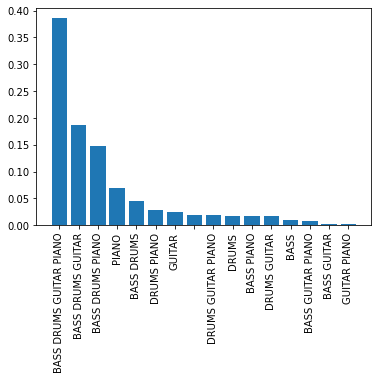

In [0]:
plt.bar([group for group, count in instr_groups_counts.most_common()], [count/(sample_size - errors_count) for group, count in instr_groups_counts.most_common()])
plt.xticks(rotation='90')
plt.show()

Since this, we now know that 42% of the 31.000 distinct songs is "valuable data" for our project. Eventhough, it is important to remark that we took one MIDI representation for each MP3 song (thats why the dataset was reduced from 116.000 to 31.000 samples). Now that we have this new scenario, we might consider taking more than one MIDI representation of each song (if it has all the 4 families of instrument in it), with the aim of increasing the dataset. Also, we will crop each song in chunks of 30 seconds, thing that will increase enormously our dataset also.

Also, we wanted to check the distributions of this 4 instruments' families in the 4 genres that we chose:

In [0]:
song_id_instruments = {k[7:-1].split("/", 1)[0]: v for k, v in instruments.items()}

In [0]:
genre_instruments = {k[7:-1].split("/", 1)[0]: v for k, v in instruments.items()}
#list(genre_instruments.keys())
#genre_instruments

In [0]:
def add_instrumnets_to_genre(d,m_id,instruments,n):
    temp_list = get_most_common(m_id,n)
    for i in temp_list:
        # Check if it is in the dict before otherwise add it
        if i in d:
            d[i].append(instruments)
        else:
            d[i] = [instruments]
    return

def instrument_counts(d):
    instrument_counts = {}
    keys = list(d.keys())
    for k in keys:
        l = list(d[k])
        #print(l)
        flat_list = [item for sublist in l for item in sublist]
        counts = Counter(flat_list)
        counts2 = {k: np.round(v/len(l),3) for k, v in counts.items()}
        instrument_counts[k] = counts2
    return instrument_counts

def plot_instruments_in_genre(genre, d):
    d_g = d[genre]
    plt.bar(d_g.keys(), d_g.values())
    plt.title(genre)
    #autolabel(rects)
    plt.xticks(rotation=90)
    plt.xlabel('instrument')
    plt.ylabel('Probability the instrument is in the genre')

    
d_instruments = {}
song_ids= list(genre_instruments.keys())
for msd_id in song_ids:
    a = get_info(msd_id)
    n = len([i for i in a if i >= 0.90])
    instruments = genre_instruments[msd_id]
    add_instrumnets_to_genre(d_instruments,msd_id,instruments,n)

instrument_counts = instrument_counts(d_instruments)    

 
 ------------------------------- Instrument frequencies in different genres --------------------------------


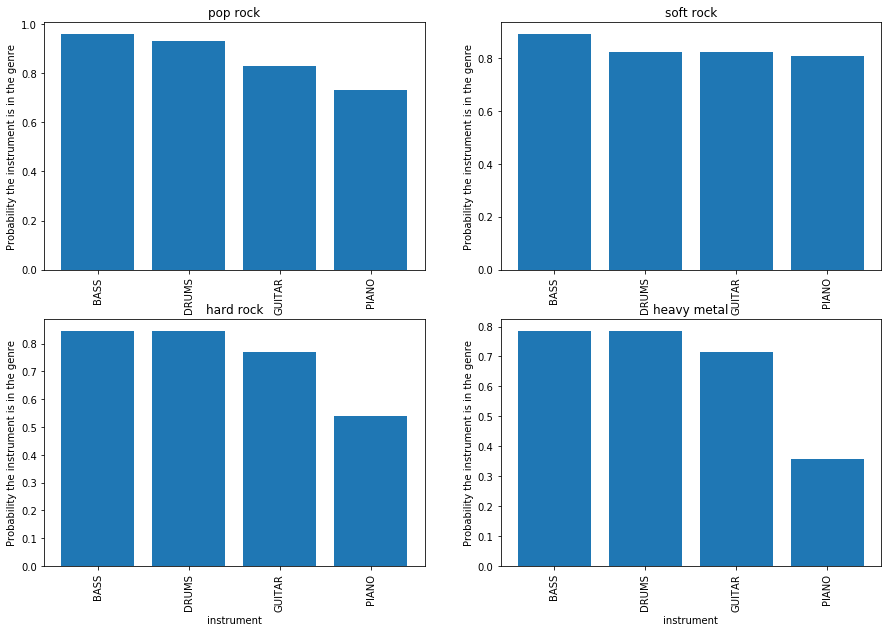

In [0]:
f, axs = plt.subplots(2,2,figsize=(15,10))
print(' \n ------------------------------- Instrument frequencies in different genres --------------------------------')

plt.subplot(2, 2, 1)
plot_instruments_in_genre('pop rock', instrument_counts)

plt.subplot(2, 2, 2)
plot_instruments_in_genre('soft rock', instrument_counts)

plt.subplot(2, 2, 3)
plot_instruments_in_genre('hard rock', instrument_counts)

plt.subplot(2, 2, 4)
plot_instruments_in_genre('heavy metal', instrument_counts)

#plt.show()


As you can see, the distribution is somehow "the same" across instrument families in all 4 genres. Then, this scenario seems to be enough useful for our project.

Lastly, here we have a small pipeline that merges instruments according to the conversion dictionary. Basically, it maps every instrument of the same "family" to the same track/channel. You could say that it does a "simplification" or "abstraction" of the MIDI file, to prepare it for the input format of the model

In [0]:
def merge_similar_instruments(pm_object, conversion_dict):
    merged_instruments_notes = defaultdict(list)
    drum_instruments = list()
    not_drum_instruments = list()
    for instrument in pm_object.instruments:
        if instrument.is_drum:
            drum_instruments.append(instrument)
        else:
            not_drum_instruments.append(instrument)
    for instrument in not_drum_instruments:
        merged_instruments_notes[conversion_dict[instrument.program]].extend(instrument.notes)
    for program_number, notes_list in merged_instruments_notes.items():
        if program_number != -1:
            notes_list.sort(key=lambda note: note.start)
    #pm_object.instruments = [pretty_midi.Instrument(program=program_number, is_drum=False) for program_number, notes_list in merged_instruments_notes.items() if program_number != -1]
    pm_object.instruments = list()
    for program_number, notes_list in merged_instruments_notes.items():
        if program_number != -1:
            new_instrument = pretty_midi.Instrument(program=program_number, is_drum=False)
            new_instrument.notes = notes_list
            pm_object.instruments.append(new_instrument)
    
    new_drum_instrument = pretty_midi.Instrument(program=0, is_drum=True)
    drums_notes = list()
    for drum_instrument in drum_instruments:
        drums_notes.extend(drum_instrument.notes)
    drums_notes.sort(key=lambda note: note.start)
    new_drum_instrument.notes = drums_notes
    pm_object.instruments.append(new_drum_instrument)

In [0]:
def midi_conversion_pipeline(midi_path, conversion_dict):
    pm_object = pretty_midi.PrettyMIDI(midi_path)
    merge_similar_instruments(pm_object, conversion_dict)
    song_name = midi_path.replace(".mid", "")
    pm_object.write(f"{song_name} [MODIFIED].mid")

In [0]:
conversion_dict = {
    0: 0, 1: 0, 2: 0, 3: 0, 4: 0, 5: 0, 6: 0, 7: 0, 8: 0, 9: 0,
    10: -1, 11: -1, 12: -1, 13: -1, 14: -1, 15: -1,
    16: 0, 17: 0, 18: 0, 19: 0, 20: 0,
    21: -1, 22: -1, 23: -1,
    24: 24, 25: 24, 26: 24, 27: 24, 28: 24, 29: 24, 30: 24, 31: 24,
    32: 32, 33: 32, 34: 32, 35: 32, 36: 32, 37: 32, 38: 32, 39: 32,
    40: -1, 41: -1, 42: -1, 43: -1, 44: -1, 45: -1, 46: -1, 47: -1, 48: -1, 49: -1, 50: -1, 51: -1, 52: -1, 53: -1, 54: -1, 55: -1, 56: -1, 57: -1, 58: -1, 59: -1, 60: -1, 61: -1, 62: -1, 63: -1, 64: -1, 65: -1, 66: -1, 67: -1, 68: -1, 69: -1, 70: -1, 71: -1, 72: -1, 73: -1, 74: -1, 75: -1, 76: -1, 77: -1, 78: -1, 79: -1, 80: -1, 81: -1, 82: -1, 83: -1, 84: -1, 85: -1, 86: -1, 87: -1, 88: -1, 89: -1, 90: -1, 91: -1, 92: -1, 93: -1, 94: -1, 95: -1, 96: -1, 97: -1, 98: -1, 99: -1, 100: -1, 101: -1, 102: -1, 103: -1, 104: -1, 105: -1, 106: -1, 107: -1, 108: -1, 109: -1, 110: -1, 111: -1, 112: -1, 113: -1, 114: -1, 115: -1, 116: -1, 117: -1, 118: -1, 119: -1, 120: -1, 121: -1, 122: -1, 123: -1, 124: -1, 125: -1, 126: -1, 127: -1
}
midi_conversion_pipeline("The Beatles - Here comes the sun.mid", conversion_dict)

Next you can listen the slight difference between the raw and proccesed midi file. Nevertheless, each channel is being played with a sine wave timbre (not the actual instrument it represents), so it's hard to tell the difference (if you play it in MuseScore you can notice a bigger difference).

In [0]:
pm = pretty_midi.PrettyMIDI("The Beatles - Here comes the sun.mid")
fs = 16000
IPython.display.Audio(pm.synthesize(fs=16000), rate=16000)
# Sounds like sine waves...

In [22]:
pm = pretty_midi.PrettyMIDI("The Beatles - Here comes the sun [MODIFIED].mid")
fs = 16000
IPython.display.Audio(pm.synthesize(fs=16000), rate=16000)
# Sounds like sine waves...

The code above is easy to understand when you see that an instrument has a list of Note's objects. Therefore, mixing instruments tracks is just mixing their list of Notes, and then sorting them by their start atribute.

In [0]:
pm.instruments[2].notes

[Note(start=0.000000, end=0.315624, pitch=44, velocity=100),
 Note(start=0.000000, end=0.315624, pitch=49, velocity=100),
 Note(start=0.946871, end=1.262494, pitch=44, velocity=100),
 Note(start=0.946871, end=1.262494, pitch=49, velocity=100),
 Note(start=5.049976, end=5.365600, pitch=44, velocity=100),
 Note(start=5.049976, end=5.365600, pitch=49, velocity=100),
 Note(start=5.996847, end=6.312470, pitch=44, velocity=100),
 Note(start=5.996847, end=6.312470, pitch=49, velocity=100),
 Note(start=4.429250, end=7.553922, pitch=54, velocity=100),
 Note(start=4.429250, end=7.559183, pitch=59, velocity=100),
 Note(start=10.099952, end=10.415576, pitch=44, velocity=100),
 Note(start=10.099952, end=10.415576, pitch=49, velocity=100),
 Note(start=11.046823, end=11.362446, pitch=44, velocity=100),
 Note(start=11.046823, end=11.362446, pitch=49, velocity=100),
 Note(start=14.203057, end=14.308265, pitch=59, velocity=100),
 Note(start=14.518681, end=15.239355, pitch=61, velocity=100),
 Note(start=

# **Questions:**

**Which analyses or experiments did you perform and what are the results? Choose suitable visualizations to show your results.**

In this section we wanted to understand how was the instrument distribution across our dataset. To measure that, we took samples of our dataset and counted which instruments were present in heach MIDI file of the sample. With that, we obtained distributions that helped us to discover which were the most frequent "instrument's families". Using those results, we decided use 4 families of instruments: pianos, basses, guitars and percussions/drums. Using this conversion, we simulated a merge of instruments, and discovered that 42% of our dataset has all 4 families of instruments. Then, we showed what was the distribution of this 4 families in the 4 genres that we chose. We noticed that all 4 genres have a quite "uniform" distribution of this instruments, which is also good news for our project.

**How do the results relate to your hypotheses?**

Maybe one impressive thing is that, before doing this, we assumed that the vast majority of the dataset would have a least one instrument of each family. As we showed, this was not the case since just 42% of the dataset has all 4 instruments. This issue can be adressed as we mentioned previously in the code anotations. 

**Did you find interesting or unexpected things? How do they influence your project?**

Besides the above mentioned, another interesting thing was the instruments mapping or merge. In some cases, the merge was pretty straight forward (e.g. mixing "Acoustic Grand Piano" and "Bright Acoustic Piano" into the same piano family), but others were not (should we consider "Organs" as pianos?). In this sense, we are open to discuss with the assistants what would be the most "accurate" mapping, but also with the aim of considering as much instruments as possible (to not reduce too much our dataset).

**What are problems that you encountered? How could you plan to deal with them?**

We don't know if its a real "problem", but in our dataset, each song has approx 3-4 different midi representations. Until now, we just took one (random) midi representation per song, but since the "42% problem", we are tempted to start making use of this left-out song. In that sense, we want to make sure that we are not biasing our dataset to "repeated" songs.

# **3. Model**

In this part we present our advance in the RNN model. The explanation is given with the questions.

In [0]:
import tensorflow as tf 
import numpy as np
import os
import time
import functools
import pickle
from IPython import display as ipythondisplay
from tqdm import tqdm
import pretty_midi
!apt-get install abcmidi timidity > /dev/null 2>&1
tf.enable_eager_execution()
is_eager_enabled = tf.executing_eagerly()
assert is_eager_enabled,      "Tensorflow eager mode is not enabled"

In [0]:
import subprocess
import regex as re

import matplotlib.pyplot as plt
from IPython import display as ipythondisplay


from IPython.display import Audio
from string import Formatter





def display_model(model):
  tf.keras.utils.plot_model(model,
             to_file='tmp.png',
             show_shapes=True)
  return ipythondisplay.Image('tmp.png')


def plot_sample(x,y,vae):
    plt.figure(figsize=(2,1))
    plt.subplot(1, 2, 1)

    idx = np.where(y==1)[0][0]
    plt.imshow(x[idx])
    plt.grid(False)

    plt.subplot(1, 2, 2)
    _, _, _, recon = vae(x)
    recon = np.clip(recon, 0, 1)
    plt.imshow(recon[idx])
    plt.grid(False)

    plt.show()



class LossHistory:
  def __init__(self, smoothing_factor=0.0):
    self.alpha = smoothing_factor
    self.loss = []
  def append(self, value):
    self.loss.append( self.alpha*self.loss[-1] + (1-self.alpha)*value if len(self.loss)>0 else value )
  def get(self):
    return self.loss

class PeriodicPlotter:
  def __init__(self, sec, xlabel='', ylabel='', scale=None):

    self.xlabel = xlabel
    self.ylabel = ylabel
    self.sec = sec
    self.scale = scale

    self.tic = time.time()

  def plot(self, data):
    if time.time() - self.tic > self.sec:
      plt.cla()

      if self.scale is None:
        plt.plot(data)
      elif self.scale == 'semilogx':
        plt.semilogx(data)
      elif self.scale == 'semilogy':
        plt.semilogy(data)
      elif self.scale == 'loglog':
        plt.loglog(data)
      else:
        raise ValueError("unrecognized parameter scale {}".format(self.scale))

      plt.xlabel(self.xlabel); plt.ylabel(self.ylabel)
      ipythondisplay.clear_output(wait=True)
      ipythondisplay.display(plt.gcf())

      self.tic = time.time()
        
cwd = os.getcwd()

def load_training_data():
    with open(os.path.join(cwd, "data", "irish.abc"), "r") as f:
        text = f.read()
    songs = extract_song_snippet(text)
    return songs

def extract_song_snippet(text):
    pattern = '\n\n(.*?)\n\n'
    search_results = re.findall(pattern, text, overlapped=True, flags=re.DOTALL)
    songs = [song for song in search_results]
    print("Found {} songs in text".format(len(songs)))
    return songs

def save_song_to_abc(song, filename="tmp"):
    save_name = "{}.abc".format(filename)
    print(save_name)
    with open(save_name, "w") as f:
        f.write(song)
    return filename

def abc2wav(abc_file):
    path_to_tool = os.path.join(cwd, 'abc2wav')
    cmd = "{} {}".format(path_to_tool, abc_file)
    print(cmd)
    return os.system(cmd)

def play_wav(wav_file):
    return Audio(wav_file)

def play_song(song):
    basename = save_song_to_abc(song)
    ret = abc2wav(basename+'.abc')
    print(ret)
   # if ret == 0: #did not suceed
        #return play_wav(basename+'.wav')
    return None

def play_generated_song(generated_text):
    songs = extract_song_snippet(generated_text)
    print(songs)
    if len(songs) == 0:
        print("No valid songs found in generated text.")

    for song in songs:
        play_song(song)
    print("None of the songs were valid, try training longer to improve \
        syntax.")

def test_batch_func_types(func, args):
    ret = func(*args)
    assert len(ret) == 2, "[FAIL] get_batch must return two arguments (input and label)"
    assert type(ret[0]) == np.ndarray, "[FAIL] test_batch_func_types: x is not np.array"
    assert type(ret[1]) == np.ndarray, "[FAIL] test_batch_func_types: y is not np.array"
    print("[PASS] test_batch_func_types")
    return True

def test_batch_func_shapes(func, args):
    dataset, seq_length, batch_size = args
    x, y = func(*args)
    correct = (batch_size, seq_length)
    assert x.shape == correct, "[FAIL] test_batch_func_shapes: x {} is not correct shape {}".format(x.shape, correct)
    assert y.shape == correct, "[FAIL] test_batch_func_shapes: y {} is not correct shape {}".format(y.shape, correct)
    print("[PASS] test_batch_func_shapes")
    return True

def test_batch_func_next_step(func, args):
    x, y = func(*args)
    assert (x[:,1:] == y[:,:-1]).all(), "[FAIL] test_batch_func_next_step: x_{t} must equal y_{t-1} for all t"
    print("[PASS] test_batch_func_next_step")
    return True

def test_custom_dense_layer_output(y):
    true_y = np.array([[0.2697859,  0.45750418, 0.66536945]],dtype='float32')
    assert tf.shape(y).numpy().tolist() == list(true_y.shape), "[FAIL] output is of incorrect shape. expected {} but got {}".format(true_y.shape, y.numpy().shape)
    np.testing.assert_almost_equal(y.numpy(), true_y, decimal=7, err_msg="[FAIL] output is of incorrect value. expected {} but got {}".format(y.numpy(), true_y), verbose=True)
    print("[PASS] test_custom_dense_layer_output")
    return True

In [0]:
path_to_file = tf.keras.utils.get_file('irish.abc', 'https://raw.githubusercontent.com/aamini/introtodeeplearning_labs/2019/lab1/data/irish.abc')
songs = open(path_to_file).read()

print ('Length of text: {} characters'.format(len(songs)))

Length of text: 197618 characters


In [0]:
songsT = extract_song_snippet(songs[:750])
print(songsT)
if len(songsT) == 0:
    print("No valid songs found in generated text. Try training the \
            model longer or increasing the amount of generated music to \
            ensure complete songs are generated!")

for song in songsT:
    save_name = "{}.abc".format('tmp')
    print(save_name)
    with open(save_name, "w") as f:
        f.write(song)

Found 1 songs in text
['X:2\nT:An Buachaill Dreoite\nZ: id:dc-hornpipe-2\nM:C|\nL:1/8\nK:G Major\nGF|DGGB d2GB|d2GF Gc (3AGF|DGGB d2GB|dBcA F2GF|!\nDGGB d2GF|DGGF G2Ge|fgaf gbag|fdcA G2:|!\nGA|B2BG c2cA|d2GF G2GA|B2BG c2cA|d2DE F2GA|!\nB2BG c2cA|d^cde f2 (3def|g2gf gbag|fdcA G2:|!']
tmp.abc


In [0]:
songs_joined = "\n\n".join(songs) 

vocab = sorted(set(songs_joined))
print("There are", len(vocab), "unique characters in the dataset")
char2idx = {u:i for i, u in enumerate(vocab)}

idx2char = np.array(vocab)
print('{')
for char,_ in zip(char2idx, range(20)):
    print('  {:4s}: {:3d},'.format(repr(char), char2idx[char]))
print('  ...\n}')

There are 83 unique characters in the dataset
{
  '\n':   0,
  ' ' :   1,
  '!' :   2,
  '"' :   3,
  '#' :   4,
  "'" :   5,
  '(' :   6,
  ')' :   7,
  ',' :   8,
  '-' :   9,
  '.' :  10,
  '/' :  11,
  '0' :  12,
  '1' :  13,
  '2' :  14,
  '3' :  15,
  '4' :  16,
  '5' :  17,
  '6' :  18,
  '7' :  19,
  ...
}


In [0]:
def vectorize_string(string):
  vectorized_output = np.array([char2idx[char] for char in string])
  return vectorized_output

vectorized_songs = vectorize_string(songs_joined)

In [0]:
def get_batch(vectorized_songs, seq_length, batch_size):
  
  n = vectorized_songs.shape[0] - 1
  
  idx = np.random.choice(n-seq_length, batch_size)

  input_batch = [vectorized_songs[i : i+seq_length] for i in idx]
  
  output_batch = [vectorized_songs[i+1 : i+seq_length+1] for i in idx]

  x_batch = np.reshape(input_batch, [batch_size, seq_length])
  y_batch = np.reshape(output_batch, [batch_size, seq_length])
  return x_batch, y_batch



In [0]:
x_batch, y_batch = get_batch(vectorized_songs, seq_length=5, batch_size=1)

for i, (input_idx, target_idx) in enumerate(zip(np.squeeze(x_batch), np.squeeze(y_batch))):
    print("Step {:3d}".format(i))
    print("  input: {} ({:s})".format(input_idx, repr(idx2char[input_idx])))
    print("  expected output: {} ({:s})".format(target_idx, repr(idx2char[target_idx])))

Step   0
  input: 0 ('\n')
  expected output: 73 ('r')
Step   1
  input: 73 ('r')
  expected output: 0 ('\n')
Step   2
  input: 0 ('\n')
  expected output: 0 ('\n')
Step   3
  input: 0 ('\n')
  expected output: 69 ('n')
Step   4
  input: 69 ('n')
  expected output: 0 ('\n')


In [0]:
def LSTM(rnn_units): 
  return tf.keras.layers.LSTM(
    rnn_units, 
    return_sequences=True, 
    recurrent_initializer='glorot_uniform',
    recurrent_activation='sigmoid',
    stateful=True,
  )
def build_model(vocab_size, embedding_dim, rnn_units, batch_size):
   
  model = tf.keras.Sequential([
   
    tf.keras.layers.Embedding(vocab_size, embedding_dim, batch_input_shape=[batch_size, None]),

    
   LSTM(rnn_units), 
    
    tf.keras.layers.Dense(vocab_size)
    
  ])

  return model

model = build_model(len(vocab), embedding_dim=256, rnn_units=1024, batch_size=32)
model.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_4 (Embedding)      (32, None, 256)           21248     
_________________________________________________________________
lstm_4 (LSTM)                (32, None, 1024)          5246976   
_________________________________________________________________
dense_4 (Dense)              (32, None, 83)            85075     
Total params: 5,353,299
Trainable params: 5,353,299
Non-trainable params: 0
_________________________________________________________________


In [0]:
x, y = get_batch(vectorized_songs, seq_length=100, batch_size=32)
pred = model(x)

print("Input shape:      ", x.shape, " # (batch_size, sequence_length)")
print("Prediction shape: ", pred.shape, "# (batch_size, sequence_length, vocab_size)")

Input shape:       (32, 100)  # (batch_size, sequence_length)
Prediction shape:  (32, 100, 83) # (batch_size, sequence_length, vocab_size)


In [0]:
def compute_loss(labels, logits):
  loss = tf.keras.losses.sparse_categorical_crossentropy(labels, logits, from_logits=True)
  return loss

example_batch_loss = compute_loss(y, pred)

print("Prediction shape: ", pred.shape, " # (batch_size, sequence_length, vocab_size)") 
print("scalar_loss:      ", example_batch_loss.numpy().mean())

Prediction shape:  (32, 100, 83)  # (batch_size, sequence_length, vocab_size)
scalar_loss:       4.4283366


In [0]:
num_training_iterations = 800
batch_size = 4  
seq_length = 100  
learning_rate = 5e-3 

 
vocab_size = 101
embedding_dim = 256 
rnn_units = 1024  

checkpoint_dir = './training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, "my_ckpt")

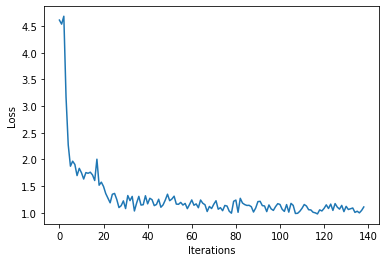

 17%|█▋        | 139/800 [15:08<1:19:11,  7.19s/it]

In [0]:
model = build_model(vocab_size, embedding_dim, rnn_units, batch_size)

optimizer = tf.keras.optimizers.Adam(learning_rate)


@tf.function
def train_step(x, y): 

  with tf.GradientTape() as tape:
  
    
    y_hat = model(x) 
  
    
    loss = compute_loss(y, y_hat) 

 
  grads = tape.gradient(loss, model.trainable_variables) # TODO
  
  optimizer.apply_gradients(zip(grads, model.trainable_variables))
  return loss



history = []
plotter = PeriodicPlotter(sec=2, xlabel='Iterations', ylabel='Loss')
if hasattr(tqdm, '_instances'): tqdm._instances.clear() 
for iter in tqdm(range(num_training_iterations)):

 
  x_batch, y_batch = get_batch(vectorized_songs, seq_length, batch_size)
  loss = train_step(x_batch, y_batch)

  history.append(loss.numpy().mean())
  plotter.plot(history)

 
  if iter % 100 == 0:     
    model.save_weights(checkpoint_prefix)
    

model.save_weights(checkpoint_prefix)


In [0]:
def generate_text(model, start_string, generation_length=1000):
  
  input_eval = [char2idx[s] for s in start_string] 
  input_eval = tf.expand_dims(input_eval, 0)
  print(input_eval)
  
  text_generated = []

  
  model.reset_states()
  tqdm._instances.clear()

  for i in tqdm(range(generation_length)):
      
      predictions = model(input_eval)
      
      predictions = tf.squeeze(predictions, 0)
      
      
      predicted_id = tf.random.categorical(predictions, num_samples=1)[-1,0].numpy()
      
      input_eval = tf.expand_dims([predicted_id], 0)
      
      text_generated.append(idx2char[predicted_id]) 
     
  return (start_string + ''.join(text_generated))

In [0]:
generated_text = generate_text(model, start_string="X", generation_length=1000) 

In [0]:
np.save('generated_text', generated_text)

In [0]:
infile = open('notes','rb')
notes = pickle.load(infile)
infile.close()
notes

In [0]:
def pm_to_array(notes):
    length = len(notes)
    notesArr =  pd.DataFrame([['']*4]*length)
    for i in range(length):
        string = str(notes[i])
        s1, s2, s3, s4, s5 = string.split('=')
        v1, t= s2.split(',')
        v2,t= s3.split(',')
        v3, t = s4.split(',')
        s5 = s5[:-1]
        notesArr[0][i] = v1
        notesArr[1][i] = v2
        notesArr[2][i] = v3
        notesArr[3][i] = s5
    return notesArr

In [0]:
notesArr = pm_to_array(notes)
notesArr[:10]

In [0]:
def encode_notes(notesArr):
    encodeNotes =  pd.DataFrame([[0.0]*23]*2000)
    length = len(notesArr)
    lastInt = 1000
    lastPart = 1000
    count = 1
    for i in range(length):
        start = notesArr[0][i]
        end = notesArr[1][i]
        dur = float(end) - float(start)
        startInt = int(float(start))
        part = float(start) - startInt
        index = (startInt-1)*4
        if(index==-4):
            index = 0
        if(part<0.25):
            partInt = 0
        elif(0.25<part<0.5):
            partInt = 1
        elif(0.5<part<0.75):
            partInt = 2
        elif(0.75<part<1.0):
            partInt = 3
        if(startInt == lastInt and lastPart == partInt):
                tCount = (count-1)*4
                encodeNotes[tCount][index + partInt] = 1
                encodeNotes[tCount+1][index + partInt] = dur
                encodeNotes[tCount+2][index + partInt] = notesArr[2][i]
                encodeNotes[tCount+3][index + partInt] = notesArr[3][i]
                lastInt = startInt
                lastPart = partInt
                count += 1
        else:
            if(count>1):
                 count = 1
            encodeNotes[0][index + partInt] = 1
            encodeNotes[1][index + partInt] = dur
            encodeNotes[2][index + partInt] = notesArr[2][i]
            encodeNotes[3][index + partInt] = notesArr[3][i]
            count += 1
            lastInt = startInt
            lastPart = partInt
    return encodeNotes

In [0]:
encodedNotes = encode_notes(notesArr)
encodedNotes[:20]

In [0]:
def build_model_n(vocab_size, embedding_dim, rnn_units, batch_size):
   
  model = tf.keras.Sequential([
   
    tf.keras.layers.Embedding(vocab_size, embedding_dim, batch_input_shape=[batch_size, None]),

    
   LSTM(rnn_units), 
    
    tf.keras.layers.Dense(vocab_size)
    
  ])

  return model

modelN = build_model_n(101, embedding_dim=256, rnn_units=1024, batch_size=1)

In [0]:



optimizer = tf.keras.optimizers.Adam(learning_rate)


@tf.function
def train_step(x, y): 

  with tf.GradientTape() as tape:
  
    
    y_hat = model(x) 
  
    
    loss = compute_loss(y, y_hat) 

 
  grads = tape.gradient(loss, model.trainable_variables) # TODO
  
  optimizer.apply_gradients(zip(grads, model.trainable_variables))
  return loss



history = []
plotter = PeriodicPlotter(sec=2, xlabel='Iterations', ylabel='Loss')
if hasattr(tqdm, '_instances'): tqdm._instances.clear() 
for iter in tqdm(range(num_training_iterations)):

 
  x_batch, y_batch = get_batch(vectorized_songs, seq_length, batch_size)
  loss = train_step(x_batch, y_batch)

  history.append(loss.numpy().mean())
  plotter.plot(history)

 
  if iter % 100 == 0:     
    model.save_weights(checkpoint_prefix)
    

model.save_weights(checkpoint_prefix)


# **Questions:**

**Which analyses or experiments did you perform and what are the results? Choose suitable visualizations to show your results.**

In this Notebook we trained a simple RNN on the strings of abc format notes to generate new song samples before deciding how to encode the midi files. We were able to achieve a substantial decrease in the loss valuee despite using a limited dataset and a small model. Then we generated new samples of songs. Next we created an encoding that takes a prettymidi list of notes and converts it to an array notation of standardized size that is suitable for feeding into a neural network. It subdivides notes onsets into standardized time steps, and a pitch, duration, and velocity values. 

**How do the results relate to your hypotheses?**

They show that our approach is theoretically viable at a small scale, and that we can convert midi to a reasonable format. 

**Did you find interesting or unexpected things? How do they influence your project?**

In this model step, nothing particularly jumped out as surprising, though we found some definite steps for moving forward. Not included in this notebook are more complicated versions of the model which take multiple instrument streams at each time step, but have yet to be converted from dummy data/ are unfinished in that regard, so I did not include them  for clarity.

**What are problems that you encountered? How could you plan to deal with them?**

The concurence of note onsets influenced/changed our encoding style substantially from our initial conception. Other than that our next steps are to finish converting the more complicated models/ loss and training functions to our new encoding style.